In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
dt = pd.read_csv('train.csv')

In [6]:
dt.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [185]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Матрица корреляции.

Вообще, по-хорошему надо ещё учитывать, что корреляция может быть стат значимой и незначимой.
И просто смотреть на матрицу корреляций не очень правильно.
Плюс, есть матрица частных коэффициентов корреляции и ещё корреляции Спирмена для ординальных переменных. 

Но это все тонкости и детали. Другой вопрос в том, для каких переменных проверять корреляцию.

Есть 7 числовых переменных: 
1. PassengerId - Id пассажира, 
2. Survived - метка выжил или нет, 
3. Pclass - класс пассажира, 1 - высший, 3 - низший),
4. Age - возраст для всех, кто старше одного года - кол-во полных лет, для остальных - дробь
5. SibSp - кол-во братьев, сестер(сводных и родных) и супругов на борту
6. Parch - кол-во родителей и детей на борту
7. Fare - плата за проезд

Из описания сразу видно, что PassengerId и Survived имеет смысл откинуть, потому что id нет смысла анализировать, а для анализа связи с меткой необходимо воспользоваться другими методами или вообще просто классификацию делать.
Для Pclass подойдет коэффициент корреляции Спирмена, потому что значения можно упорядочить 1>2>3, но в задаче требудется только коэффициент корреляции Пирсона, так что откинем.

Для остальных уже имеет смысл строить матрицу корреляций

In [39]:
dt[['Age','SibSp','Parch','Fare']].corr()

,Age,SibSp,Parch,Fare
Age,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.308247,1.000000,0.414838,0.159651
Parch,-0.189119,0.414838,1.000000,0.216225
Fare,0.096067,0.159651,0.216225,1.000000


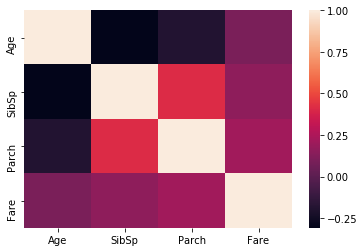

In [40]:
#Just because I can
sns.heatmap(dt[['Age','SibSp','Parch','Fare']].corr())
plt.show()

In [41]:
#More sexy heatmap
dt[['Age','SibSp','Parch','Fare']].corr().style.set_properties(**{'color':'black'}).background_gradient(cmap='coolwarm').set_precision(2)

,Age,SibSp,Parch,Fare
Age,1,-0.31,-0.19,0.096
SibSp,-0.31,1,0.41,0.16
Parch,-0.19,0.41,1,0.22
Fare,0.096,0.16,0.22,1


Гистограммы

В статистике гистограммы используют для вызуального представления функции плотности вероятности случайной величины, построенной по выборке.

Вполне логично было бы построить их только для переменных, которые были использованы для построения матрицы корреляции. Но это не очень интересно, поэтому для для других переменных будет построена столбчатая диаграмма

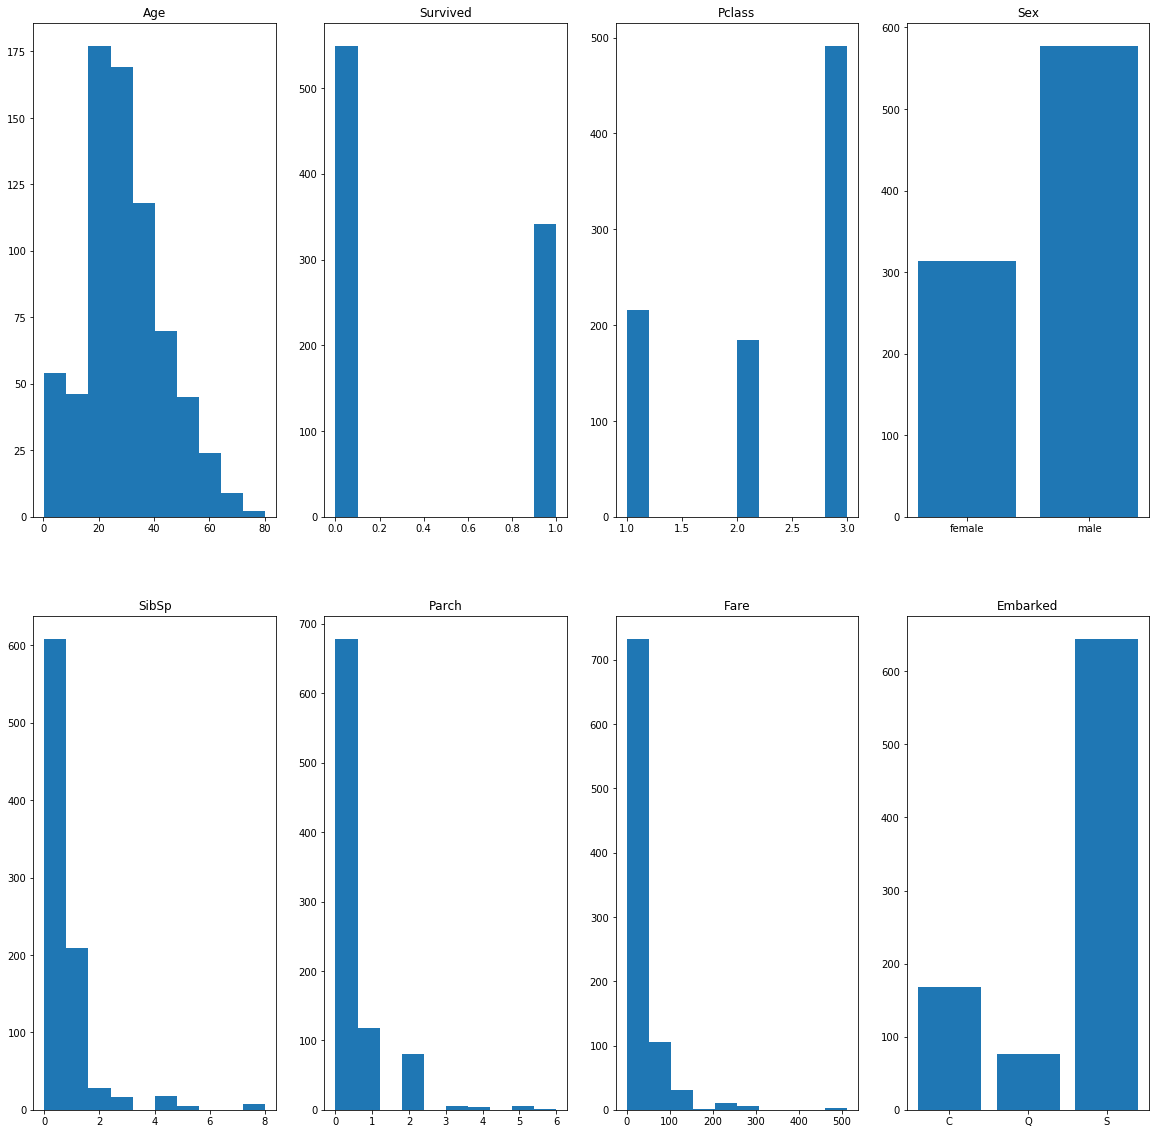

In [66]:
fig, ax = plt.subplots(nrows = 2, ncols =4, figsize =(20,20))
ax[0,0].hist(dt['Age'])
ax[0,0].set_title('Age')
ax[0,1].hist(dt['Survived'])
ax[0,1].set_title('Survived')
ax[0,2].hist(dt['Pclass'])#Используетмся метод hist() просто потому что так быстрее
ax[0,2].set_title('Pclass')
genders = dt.groupby('Sex')['PassengerId'].count().to_dict()
ax[0,3].bar(x = list(genders.keys()) , height = list(genders.values()))
ax[0,3].set_title('Sex')
ax[1,0].hist(dt['SibSp'])
ax[1,0].set_title('SibSp')
ax[1,1].hist(dt['Parch'])
ax[1,1].set_title('Parch')
ax[1,2].hist(dt['Fare'])
ax[1,2].set_title('Fare')
cities = dt.groupby('Embarked')['PassengerId'].count().to_dict()
ax[1,3].bar(x = list(cities.keys()) , height = list(cities.values()))
ax[1,3].set_title('Embarked')
plt.show()

Посчитать самое популярное женское имя.

Вроде тут всё просто: взять тех, кого женский пол(неожиданно, да?) и дальше достать оттуда имя и просто посчитать для каждого сколько раз встречается, и вывести самое популярное.

Казалось бы, что тут сложного...

Вообще, дамы делятся на 2 вида: те, кто miss(незамужем) и те, кто mrs(замужем).

Для незамужних структура такая: Фамилия, Miss. Имя. Тут все просто, берем просто все, что после Miss и до первого пробела.
С замужними все сложнее(удивительно, не правда ли?): Фамалия, Mrs. имя мужа(не всегда) (имя и девичья фамилия). Тут надо брать между открывающеся скобочкой и пробельчиком.

Возможны случаи двойного имени(Lily May) или более сложного, с таким можно борорться 2 способами: взять все что между открывающейся скобочкой и последним побелом или забить...

Но тут не идет крутой data science, поэтому будет взято первое имя. Плюс, девушек с двойным именем можно называть только первым именем, так что такое допущение при подсчете законно(но это не точно)

In [68]:
dt[dt['Sex'] == 'female']['Name'].head(15)

1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
18    Vander Planke, Mrs. Julius (Emelia Maria Vande...
19                              Masselmani, Mrs. Fatima
22                          McGowan, Miss. Anna "Annie"
24                        Palsson, Miss. Torborg Danira
25    Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...
28                        O'Dwyer, Miss. Ellen "Nellie"
Name: Name, dtype: object

In [69]:
names = dt[dt['Sex'] == 'female']['Name']

In [183]:
only_names = names.apply(lambda x: x[x.index('. ')+2:].split(" ")[0] if 'Miss' in x 
                            else( x[x.index(' (')+1:].split(" ")[0]  if 'Mrs.' in x and '(' in x 
                                 else x.split(" ")[2]))
#Как оказалось, там не всегда есть скобочка или имя мужа...
#Обрезание лишних скобочек
only_names = only_names.apply(lambda x: x.rstrip(")").lstrip("("))
#То, что написано ниже должно вызывать у тех, кто нормально умеет в питон боль и страдания. 
#И вообще, думаю, что так писать не стоит
only_names = pd.DataFrame(only_names)
only_names = pd.DataFrame({'count':only_names.groupby('Name')['Name'].count()}).reset_index()
print(only_names[only_names['count'] == only_names['count'].max()])

    Name  count
13  Anna     15


Расчет среднего и медианного возраста.

Не самое прикольное задание, но у меня просто написано посчитать это, а кретивить мне лень.

Но можно наложить супер хитрых фильтров, для выделения супер хитрой группы и в ней посчитать это все.
Например, средний возраст несовершеннлолетних(те, кому меньше 18 лет)

In [188]:
print('Средний возраст = {0}'.format(dt['Age'].mean()))
print('Медианный возраст = {0}'.format(dt['Age'].median()))

Средний возраст = 29.69911764705882
Медианный возраст = 28.0


In [217]:
print('Средний возраст незамужних дам = {0}'.format(dt[dt['Age'] <= 18]['Age'].mean()))
print('Медианный возраст незамужних дам  = {0}'.format(dt[dt['Age'] <= 18]['Age'].median()))

Средний возраст незамужних дам = 10.71705035971223
Медианный возраст незамужних дам  = 13.0


In [222]:
filter = dt[dt['Sex'] == 'female']['Name'].apply(lambda x: True if 'Miss' in x else False)
dt.where().groupby(['Embarked','Pclass'])['PassengerId'].count().reset_index()
#Таким образом если можно узнать сколько бы людей выжило, если бы они не зашли на борт или вышли в порту

,Embarked,Pclass,PassengerId
0,C,1.0,21
1,C,2.0,3
2,C,3.0,14
3,Q,1.0,1
4,Q,2.0,2
5,Q,3.0,30
6,S,1.0,23
7,S,2.0,29
8,S,3.0,58
